- base version: exp002
- add: model を resnet50 に変更

In [1]:
import os
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


%matplotlib inline
sns.set_style("whitegrid")

In [2]:
from dataclasses import dataclass, field
from glob import glob

import torch


@dataclass
class InputPath:
    _prefix: str = "../input"
    train_images: str = f"{_prefix}/christ-train-imgs.npz"
    train_labels: str = f"{_prefix}/christ-train-labels.npz"
    test_images: str = f"{_prefix}/christ-test-imgs.npz"
    images_prefix: str = f"{_prefix}/data/train/0"
        
        
@dataclass
class OutputPath:
    _prefix: str = "../output"
    model: str = f"{_prefix}/model"
    submission: str = f"{_prefix}/submission"

        
@dataclass
class Basic:
    run_name: str = "exp005"
    is_debug: bool = False
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
        
        
@dataclass
class Kfold:
    number: int = 5
    method: str = "skf"
    shuffle: bool = True
    columns: List[str] = field(default_factory=lambda: ["target"])
        
        
@dataclass
class Adam:
    name: str = "Adam"
    lr: float = 1e-5
    weight_decay: float = 0
    amsgrad: bool = False
        
        
@dataclass
class ReduceLROnPlateau:
    name: str = "ReduceLROnPlateau"
    mode: str = "min"
    factor: float = 0.1
    patience: int = 5
    verbose: bool = True
    eps: float = 1e-8

        
@dataclass
class Params:
    model_name: str = "resnet50"
    batch_size: int = 64
    test_batch_size: int = 256
    epochs: int = 3 if Basic.is_debug else 100
    image_size: int = 224
    num_workers: int = 0
    target_size: int = 13
    # Union[Adam]
    optimizer: Adam = Adam()
    # Union[CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau]
    scheduler: ReduceLROnPlateau = ReduceLROnPlateau()
    pretrained: bool = True
    num_aug: int = 5
    num_tta: int = 5
    early_stopping_rounds: int = 20


@dataclass
class ModelConfig:
    basic: Basic = Basic()
    kfold: Kfold = Kfold()
    params: Params = Params()

In [3]:
# for x in os.listdir(OutputPath.model):
#     if x.startswith(f"{Basic.run_name}_"):
#         os.remove(f"{OutputPath.model}/{x}")

In [4]:
past_sessions = [x.split("_")[0] for x in os.listdir(OutputPath.model) if x.endswith("_0.pth")]
assert Basic.run_name not in past_sessions

In [5]:
import math
import os
import random
import time

import joblib
import numpy as np
import torch
from sklearn import metrics


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class Jbl:
    @staticmethod
    def load(filepath: str) -> Any:
        return joblib.load(filepath)

    @staticmethod
    def save(obj_: Any, filepath: str) -> None:
        joblib.dump(obj_, filepath, compress=3)


def fix_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
    
def time_since(since: time.time, percent: float) -> str:
    def as_minutes(s):
        m = math.floor(s / 60)
        s -= m * 60
        return "%dm %ds" % (m, s)

    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (as_minutes(s), as_minutes(rs))

In [6]:
import numpy as np


def load_npz(path: str) -> np.array:
    x = np.load(path)["arr_0"]
    return x

In [7]:
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    StratifiedKFold,
    TimeSeriesSplit,
)


def generate_kf(cfg: ModelConfig) -> Generator:
    if cfg.kfold.method == "kf":
        kf = KFold(
            n_splits=cfg.kfold.number,
            shuffle=cfg.kfold.shuffle,
            random_state=cfg.basic.seed,
        )
    elif cfg.kfold.method == "skf":
        kf = StratifiedKFold(
            n_splits=cfg.kfold.number,
            shuffle=cfg.kfold.shuffle,
            random_state=cfg.basic.seed,
        )
    elif cfg.kfold.method == "gkf":
        kf = GroupKFold(n_splits=cfg.kfold.number)
    elif cfg.kfold.method == "sgkf":
        kf = StratifiedGroupKFold(
            n_splits=cfg.kfold.number, random_state=cfg.basic.seed
        )
    elif cfg.kfold.method == "tskf":
        kf = TimeSeriesSplit(n_splits=cfg.kfold.number)
    else:
        raise ValueError(f"{cfg.kfold.method} is not supported")
    return kf

In [8]:
import pandas as pd
from PIL import Image
from torch.utils import data
from torchvision import transforms as T


IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]


class ProbSpaceDataset(data.Dataset):
    def __init__(self, images: np.array, labels: Optional[np.array] = None, is_train: bool = True) -> None:
        """images.shape: (b, h, w, c), labels: (b,)"""
        assert (is_train and labels is not None) or (not is_train and labels is None)        
        self.is_train = is_train
        self.images = images
        self.labels = labels
        
        size = (ModelConfig.params.image_size, ModelConfig.params.image_size)
        additional_items = (
            [
                T.ToPILImage(),
                T.Resize(size),
            ]
            if not is_train
            else [
                T.ToPILImage(),
                T.RandomGrayscale(p=0.2),
                T.RandomHorizontalFlip(),
                T.ColorJitter(
                    brightness=0.3,
                    contrast=0.5,
                    saturation=[0.8, 1.3],
                    hue=[-0.05, 0.05],
                ),
                T.RandomResizedCrop(size),
            ]
        )
        self.transformer = T.Compose(
            [*additional_items, T.ToTensor(), T.Normalize(mean=IMG_MEAN, std=IMG_STD)]
        )

    def __getitem__(self, index) -> Dict[str, Any]:
        image = self.images[index]
        image = self.transformer(image)
        if self.is_train:
            label = self.labels[index]
        else:
            label = -1
        return {"image": image, "label": label}

    def __len__(self) -> int:
        return len(self.images)

In [9]:
import os
import sys

import timm
import torch
from torch import nn


class ProbSpaceModel(nn.Module):
    def __init__(self, model_config: ModelConfig):
        super().__init__()
        self.backbone = timm.create_model(model_config.params.model_name, pretrained=model_config.params.pretrained)
        self.in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(self.in_features, model_config.params.target_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.softmax(x)
        return x


def build_model(model_config: ModelConfig):
    model = ProbSpaceModel(model_config)
    model.to(model_config.basic.device)
    return model

In [10]:
import datetime
import time
from collections import OrderedDict
from logging import Logger
from typing import Dict, Union

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm


class BaseRunner:
    def __init__(self, cfg: ModelConfig):
        self.cfg = cfg
        self.params = cfg.params

    def _get_scheduler(
        self, optimizer: Union[optim.Adam]
    ) -> Union[
        lr_scheduler.ReduceLROnPlateau,
    ]:
        if self.params.scheduler.name == "ReduceLROnPlateau":
            scheduler = lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode=self.params.scheduler.mode,
                factor=self.params.scheduler.factor,
                patience=self.params.scheduler.patience,
                verbose=self.params.scheduler.verbose,
                eps=self.params.scheduler.eps,
            )
        else:
            raise ValueError(f"{self.params.scheduler.name} is not supported")
        return scheduler

    def _step_scheduler(
        self,
        scheduler: Union[
            lr_scheduler.ReduceLROnPlateau,
        ],
        avg_val_loss,
    ) -> Union[
        lr_scheduler.ReduceLROnPlateau,
    ]:
        if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            raise ValueError(f"{self.params.shceduler.name} is not supported")
        return scheduler

    def _evaluate(self, y_true: np.array, y_pred: np.array, verbose: bool = False) -> float:
        score = metrics.accuracy_score(y_true, y_pred)
        if verbose:
            print(f"Score: {score:<.5f}")
        return score


class TrainRunner(BaseRunner):
    def _train_epoch(self, train_loader, model, criterion, optimizer, scheduler, epoch):
        losses = AverageMeter()
        model.train()
        for _ in range(self.cfg.params.num_aug):
            for step, image_label_dict in enumerate(train_loader):
                images = image_label_dict.get("image").to(self.cfg.basic.device)
                labels = image_label_dict.get("label").to(self.cfg.basic.device)
                batch_size = labels.size(0)

                y_preds = model(images)
                loss = criterion(y_preds, labels)
                losses.update(loss.item(), batch_size)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        return losses.avg

    def _valid_epoch(self, valid_loader, model, criterion):
        losses = AverageMeter()
        model.eval()
        preds = []
        for _, image_label_dict in enumerate(valid_loader):
            images = image_label_dict.get("image").to(self.cfg.basic.device)
            labels = image_label_dict.get("label").to(self.cfg.basic.device)
            batch_size = labels.size(0)

            with torch.no_grad():
                y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            preds.append(y_preds.to("cpu").numpy())
        predictions = np.concatenate(preds).reshape(-1, self.params.target_size)
        return losses.avg, predictions

    def _train(self, train: pd.DataFrame, n_fold: int) -> pd.DataFrame:
        print(f"fold: {n_fold}")
        train_images = load_npz(InputPath.train_images)
        train_labels = load_npz(InputPath.train_labels)        
        
        is_tta_mode = self.params.num_tta > 0
        num_times_tta = 1 if not is_tta_mode else self.params.num_tta

        trn_idx = train[train["fold"] != n_fold].index.tolist()
        val_idx = train[train["fold"] == n_fold].index.tolist()
        train_images_folds = train_images[trn_idx]
        valid_images_folds = train_images[val_idx]
        train_labels_folds = train_labels[trn_idx]
        valid_labels_folds = train_labels[val_idx]
        train_folds = train.loc[trn_idx].reset_index(drop=True)
        valid_folds = train.loc[val_idx].reset_index(drop=True)
        train_dataset = ProbSpaceDataset(
            train_images_folds,
            train_labels_folds,
            is_train=True,
#             transform=get_transforms(self.params, data="train"),
        )
        valid_dataset = ProbSpaceDataset(
            valid_images_folds,
            valid_labels_folds,
            is_train=is_tta_mode,
#             transform=get_transforms(self.params, data="valid"),
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.params.batch_size,
            shuffle=True,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=True,
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=self.params.batch_size,
            shuffle=False,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=False,
        )

        model = build_model(model_config=self.cfg)
        model.to(self.cfg.basic.device)
        optimizer = optim.Adam(
            model.parameters(),
            lr=self.params.optimizer.lr,
            weight_decay=self.params.optimizer.weight_decay,
            amsgrad=self.params.optimizer.amsgrad,
        )
        scheduler = self._get_scheduler(optimizer)
        criterion = nn.CrossEntropyLoss()
        
        best_model = None
        best_score = 0
        scores: List[float] = []
        num_not_improved = 0
        for epoch in range(self.params.epochs):
            start_time = time.time()

            avg_loss = self._train_epoch(
                train_loader, model, criterion, optimizer, scheduler, epoch
            )
            avg_val_loss_list: List[float] = []
            preds_array = np.zeros((num_times_tta, len(val_idx), self.params.target_size))
            for i in range(num_times_tta):
                avg_val_loss, preds = self._valid_epoch(valid_loader, model, criterion)
                avg_val_loss_list.append(avg_val_loss)
                preds_array[i] = preds
            avg_val_loss = np.mean(avg_val_loss_list)
            scheduler = self._step_scheduler(scheduler, avg_val_loss)

            preds = preds_array.mean(axis=0)
            preds_ = np.argmax(preds, axis=1)
            valid_labels = valid_folds["target"].values
            score = self._evaluate(valid_labels, preds_)
            scores.append(score)
            elapsed = time.time() - start_time
            print(
                f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
            )
            print(f"Epoch {epoch+1} - Accuracy: {score}")
            if score > best_score:
                best_model = model
                best_score = score
                num_not_improved = 0
            else:
                num_not_improved += 1
            print(
                f"Epoch {epoch+1} - Best Score: {best_score:.4f}"
            )
            if self.params.early_stopping_rounds > 0 and self.params.early_stopping_rounds == num_not_improved:
                print(f"Early stopping break: not improved {num_not_improved} times in a row")
                break

        torch.save(
            {
                "model": best_model.state_dict(), 
                "preds": preds, 
                "best_score": best_score, 
                "scores": scores
            },
            f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth",
        )
        check_point: Dict[str, Union[OrderedDict, torch.Tensor]] = torch.load(
            f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth"
        )
        valid_folds["preds"] = np.argmax(check_point["preds"], axis=1)
        return valid_folds

    def run_cv(self, train: pd.DataFrame) -> None:
        print(f"debug mode: {self.cfg.basic.is_debug}")
        print(f"start time: {datetime.datetime.now()}")
        oof_df = pd.DataFrame()
        for n_fold in range(self.cfg.kfold.number):
            _oof_df = self._train(train, n_fold)
            print(f"========== fold: {n_fold} result ==========")
            self._evaluate(_oof_df["target"], _oof_df["preds"], verbose=True)
            oof_df = pd.concat([oof_df, _oof_df])
        print("========== CV ==========")
        self._evaluate(oof_df["target"], oof_df["preds"], verbose=True)
        Jbl.save(oof_df, f"{OutputPath.model}/oof_df_{self.cfg.basic.run_name}.jbl")

In [21]:
class InferenceRunner(BaseRunner):
    def _test_epoch(self, test_loader, model):
        model.eval()
        preds = []
        for step, image_label_dict in enumerate(test_loader):
            images = image_label_dict.get("image").to(self.cfg.basic.device)
            with torch.no_grad():
                y_preds = model(images)
            preds.append(y_preds.to("cpu").numpy())
        predictions = np.concatenate(preds).reshape(-1, self.params.target_size)
        return predictions

    def _test(self, test: pd.DataFrame, n_fold: int):
        print(f"fold: {n_fold}")
        test_images = load_npz(input_path.test_images)
        
        is_tta_mode = self.params.num_tta > 0
        num_times_tta = 1 if not is_tta_mode else self.params.num_tta
        
        test_dataset = ProbSpaceDataset(
            test_images,
            is_train=False,
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=self.params.test_batch_size,
            shuffle=False,
            num_workers=self.params.num_workers,
            pin_memory=True,
            drop_last=False,
        )

        model = build_model(model_config=self.cfg)
        model_state = torch.load(f"{OutputPath.model}/{self.cfg.basic.run_name}_{n_fold}.pth")["model"]
        model.load_state_dict(model_state)
        model.to(self.cfg.basic.device)
        # preds = self._test_epoch(test_loader, model)
        preds_array = np.zeros((num_times_tta, len(test_images), self.params.target_size))
        for i in range(num_times_tta):
            _preds = self._test_epoch(test_loader, model)
            preds_array[i] = _preds
        preds = preds_array.mean(axis=0)
        return preds
    
    def _submit(self, preds: np.array) -> None:
        test_images = load_npz(input_path.test_images)
        df_sub = pd.DataFrame({"id": list(range(len(test_images)))})
        df_sub = df_sub.assign(y=preds)
        print(df_sub.head())
        df_sub = df_sub.astype(int)
        path = f"{OutputPath.submission}/submission_{self.cfg.basic.run_name}.csv"
        df_sub.to_csv(path, index=False)
        print("submission.csv created")

    def run_cv(self, test: pd.DataFrame = None) -> None:
        oof_df = pd.DataFrame()
        preds: List[np.array] = []
        for n_fold in range(self.cfg.kfold.number):
            preds_fold = self._test(test, n_fold)
            preds.append(preds_fold)
        Jbl.save(preds, f"{OutputPath.model}/preds_test_{self.cfg.basic.run_name}.jbl")
        
        preds_mean = np.mean(preds, axis=0)
        assert preds_mean.shape == (497, 13)
        preds_mean = preds_mean.argmax(axis=1)
        assert preds_mean.shape == (497,)
        self._submit(preds_mean)

In [12]:
fix_seed()
input_path = InputPath()
model_config = ModelConfig()

In [13]:
train_labels = load_npz(InputPath.train_labels)

train = pd.DataFrame({"target": train_labels})

In [14]:
kf = generate_kf(model_config)
if model_config.kfold.method.endswith("gkf"):
    kf_generator = kf.split(
        train,
        train[self.fe_cfg.column.target],
        groups=train[self.kfold.columns],
    )
else:
    kf_generator = kf.split(train, train["target"])
for fold_i, (tr_idx, val_idx) in enumerate(kf_generator):
    print(
        f"fold: {fold_i} - {tr_idx[:5]}~{tr_idx[-5:]} ({len(tr_idx)})\t{val_idx[:5]}~{val_idx[-5:]} ({len(val_idx)})"
    )
    train.loc[val_idx, "fold"] = fold_i
train = train.assign(fold = train["fold"].astype(int))
# if model_config.kfold.method == "skf":
#     pd.set_option("display.max_rows", 65)
#     display(train.groupby(["fold", "target"]).size().to_frame())

fold: 0 - [1 2 3 6 7]~[645 646 648 651 653] (523)	[ 0  4  5 11 17]~[644 647 649 650 652] (131)
fold: 1 - [0 1 2 4 5]~[649 650 651 652 653] (523)	[ 3  6  8  9 12]~[636 638 641 645 648] (131)
fold: 2 - [0 1 3 4 5]~[649 650 651 652 653] (523)	[ 2 13 14 18 21]~[629 631 632 633 646] (131)
fold: 3 - [0 2 3 4 5]~[648 649 650 651 652] (523)	[ 1 10 15 16 27]~[611 614 628 639 653] (131)
fold: 4 - [0 1 2 3 4]~[648 649 650 652 653] (524)	[ 7 22 23 24 25]~[622 635 637 643 651] (130)


In [15]:
%%time
TrainRunner(model_config).run_cv(train)

debug mode: False
start time: 2021-08-06 08:15:05.521933
fold: 0
Epoch 1 - avg_train_loss: 2.5601  avg_val_loss: 2.5551  time: 27s
Epoch 1 - Accuracy: 0.183206106870229
Epoch 1 - Best Score: 0.1832
Epoch 2 - avg_train_loss: 2.5367  avg_val_loss: 2.5232  time: 27s
Epoch 2 - Accuracy: 0.22137404580152673
Epoch 2 - Best Score: 0.2214
Epoch 3 - avg_train_loss: 2.4764  avg_val_loss: 2.4878  time: 27s
Epoch 3 - Accuracy: 0.22137404580152673
Epoch 3 - Best Score: 0.2214
Epoch 4 - avg_train_loss: 2.4466  avg_val_loss: 2.4746  time: 27s
Epoch 4 - Accuracy: 0.22137404580152673
Epoch 4 - Best Score: 0.2214
Epoch 5 - avg_train_loss: 2.4245  avg_val_loss: 2.4582  time: 27s
Epoch 5 - Accuracy: 0.24427480916030533
Epoch 5 - Best Score: 0.2443
Epoch 6 - avg_train_loss: 2.3978  avg_val_loss: 2.4401  time: 27s
Epoch 6 - Accuracy: 0.26717557251908397
Epoch 6 - Best Score: 0.2672
Epoch 7 - avg_train_loss: 2.3752  avg_val_loss: 2.4157  time: 27s
Epoch 7 - Accuracy: 0.26717557251908397
Epoch 7 - Best Score:

In [16]:
# _oof_df = Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")
# print("========== CV ==========")
# TrainRunner(model_config)._evaluate(_oof_df["target"], _oof_df["preds"], verbose=True)

Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")

,target,fold,preds
0,5,0,5
1,6,0,2
2,4,0,5
3,7,0,7
4,0,0,0
...,...,...,...
125,3,4,11
126,11,4,4
127,5,4,5
128,9,4,9


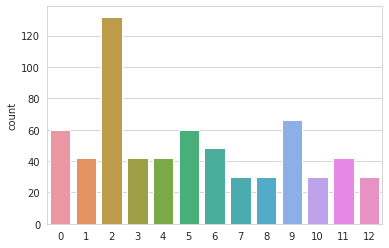

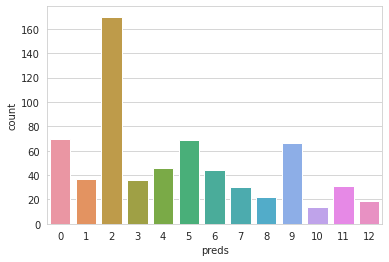

In [17]:
sns.countplot(x=train_labels, label="true")
plt.show()
sns.countplot(x=Jbl.load(f"{OutputPath.model}/oof_df_{model_config.basic.run_name}.jbl")["preds"])
plt.show()

In [22]:
InferenceRunner(model_config).run_cv()

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
   id   y
0   0   2
1   1   3
2   2  10
3   3   0
4   4   1
submission.csv created
